<a href="https://colab.research.google.com/github/Dev-jalexx/Pytorch/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")

In [ ]:
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
data_df.dropna(inplace = True)# Drops any missing values
data_df.drop(['id'], axis=1, inplace=True) #axis=1 means it is a column not a row, a row axis=0
print(data_df.shape)

(18185, 11)


In [ ]:
print(data_df.head())

   Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  4537        92.229316        64.012769      0.719916        4677   
1  2872        74.691881        51.400454      0.725553        3015   
2  3048        76.293164        52.043491      0.731211        3132   
3  3073        77.033628        51.928487      0.738639        3157   
4  3693        85.124785        56.374021      0.749282        3802   

   EquivDiameter    Extent  Perimeter  Roundness  AspectRation  Class  
0      76.004525  0.657536    273.085   0.764510      1.440796      1  
1      60.471018  0.713009    208.317   0.831658      1.453137      1  
2      62.296341  0.759153    210.012   0.868434      1.465950      1  
3      62.551300  0.783529    210.657   0.870203      1.483456      1  
4      68.571668  0.769375    230.332   0.874743      1.510000      1  


In [ ]:
print(data_df['Class'].unique())# Inspect the possible values within a column

[1 0]


In [ ]:
print(data_df['Extent'].unique())

[0.65753623 0.71300894 0.75915318 ... 0.56128748 0.49239921 0.48997524]


In [ ]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [ ]:
print(data_df['Extent'].value_counts())

Extent
0.666667    4
0.500000    4
0.735849    4
0.571429    3
0.534921    3
           ..
0.469972    1
0.594537    1
0.493611    1
0.469421    1
0.585332    1
Name: count, Length: 18007, dtype: int64


In [ ]:
# Data preprocessing
original_df = data_df.copy()# Preserves original copy of the dataframe ie the unscaled version
# Max Absolute scaling .....normalizes data to values btn -1 and 1
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [ ]:
X = np.array(data_df.iloc[:, :-1]) # .iloc Selects data based on numerical position... All the rows and all the columns except the last one
Y= np.array(data_df.iloc[:, -1]) # select all rows and only the last column


In [ ]:
# Training Data splitting
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [ ]:
# Validation data splitting
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size=0.5)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [ ]:
# Create dataset class....
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device) # Move the converted tensor from the CPU to GPU
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device) # Move the converted tensor from the CPU to GPU
  def __len__(self):# Determine total number of samples
    return len(self.X)
  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [ ]:
# Create three separate datasets
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [ ]:
#Create the  dataloaders
training_dataloader = DataLoader(training_data, batch_size =32, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size =32, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size =32, shuffle = True)

In [ ]:
for x, y in training_dataloader:
  print(x)
  print("======")
  print(y)
  break

tensor([[0.6973, 0.7784, 0.7822, 0.9223, 0.6572, 0.8350, 0.7656, 0.6680, 0.8570,
         0.5646],
        [0.9298, 0.9294, 0.8738, 0.9370, 0.8975, 0.9642, 0.8320, 0.8085, 0.7801,
         0.6034],
        [0.6547, 0.7585, 0.7517, 0.9255, 0.6252, 0.8091, 0.8095, 0.6509, 0.8474,
         0.5724],
        [0.3992, 0.5686, 0.6155, 0.9030, 0.3799, 0.6318, 0.6966, 0.5033, 0.8644,
         0.5241],
        [0.6297, 0.8241, 0.6687, 0.9628, 0.6035, 0.7935, 0.6632, 0.6802, 0.7465,
         0.6992],
        [0.5751, 0.8151, 0.6135, 0.9731, 0.5488, 0.7584, 0.8716, 0.6618, 0.7200,
         0.7538],
        [0.6488, 0.8798, 0.6417, 0.9769, 0.6166, 0.8055, 0.5146, 0.7075, 0.7108,
         0.7779],
        [0.9256, 0.9080, 0.8848, 0.9293, 0.8834, 0.9621, 0.6348, 0.7997, 0.7938,
         0.5822],
        [0.8261, 0.8391, 0.8599, 0.9175, 0.7905, 0.9089, 0.6930, 0.7419, 0.8231,
         0.5536],
        [0.5716, 0.7958, 0.6229, 0.9679, 0.5464, 0.7560, 0.5612, 0.6600, 0.7196,
         0.7249],
        [0

In [ ]:
hidden_neurons = 10
class myModel(nn.Module):
  def __init__(self):
    super(myModel, self).__init__()
    self.input_layer = nn.Linear(X.shape[1], hidden_neurons)
    self.linear = nn.Linear(hidden_neurons, 1)
    self.Sigmoid = nn.Sigmoid() # defines the activation function used on the final output to squash the raw scores (logits) into a probability (a value between 0 and 1).
  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.Sigmoid(x)
    return x
model =  myModel().to(device)

In [ ]:
summary(model, (X.shape[1],)) # summary of the neural network model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()
optimizer =  Adam(model.parameters(), lr = 1e-3)

In [ ]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in training_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)

      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item()

      acc = ((prediction).round() == labels).sum().item()
      total_acc_val += acc
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() *100, 4))

  print(f'''Epoch no.{epoch+1} Train loss: {round(total_loss_train/1000, 4)} Train accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}
        Validation loss:{round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__() *100, 4)}''')
  print("="*25)

Epoch no.1 Train loss: 0.0573 Train accuracy: 98.5781
        Validation loss:0.0162 Validation Accuracy: 98.2038
Epoch no.2 Train loss: 0.0572 Train accuracy: 98.5781
        Validation loss:0.0163 Validation Accuracy: 98.2038
Epoch no.3 Train loss: 0.0571 Train accuracy: 98.5781
        Validation loss:0.0162 Validation Accuracy: 98.2038
Epoch no.4 Train loss: 0.0571 Train accuracy: 98.5859
        Validation loss:0.0161 Validation Accuracy: 98.2405
Epoch no.5 Train loss: 0.0569 Train accuracy: 98.5938
        Validation loss:0.0161 Validation Accuracy: 98.2038
Epoch no.6 Train loss: 0.0567 Train accuracy: 98.5938
        Validation loss:0.0171 Validation Accuracy: 98.2038
Epoch no.7 Train loss: 0.0592 Train accuracy: 98.5859
        Validation loss:0.016 Validation Accuracy: 98.2405
Epoch no.8 Train loss: 0.059 Train accuracy: 98.5938
        Validation loss:0.0159 Validation Accuracy: 98.2771
Epoch no.9 Train loss: 0.0588 Train accuracy: 98.6016
        Validation loss:0.0159 Valid

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels).item()
    total_loss_test += batch_loss

    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f'''Testing accuracy: {round(total_acc_test/testing_data.__len__() * 100, 4)}''')

Testing accuracy: 98.9736


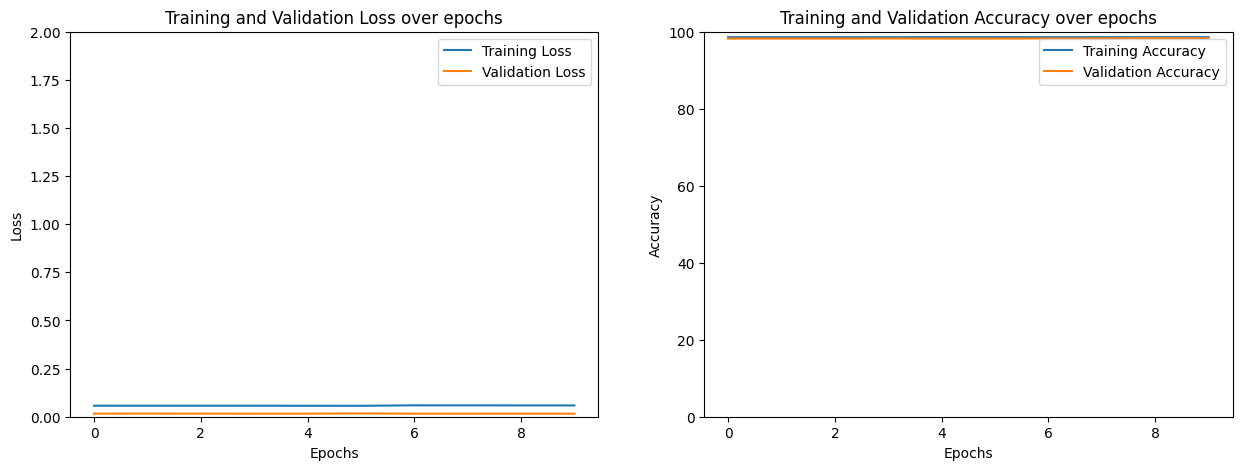

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation Loss over epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()